In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#drive.flush_and_unmount(timeout_ms=24)

In [3]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import CSVLogger, LambdaCallback

In [55]:
dataset_dir = "drive/My Drive/Plant_Leaf_MalayaKew_MK_Dataset/"
work_dir = "drive/My Drive/Plant_Leaf_MalayaKew_MK_Dataset/Records/"

In [ ]:
'''
list_categories = [f"Class{i}" for i in range(1,45)]
num_classes = len(list_categories)
print('num_classes =', num_classes)
#'''

num_classes = 44


In [ ]:
# Saving files:
'''
np.save(work_dir+"np_test_imageset.pkl", np_test_imageset, allow_pickle=True)
np.save(work_dir+"np_val_imageset.pkl", np_val_imageset, allow_pickle=True)
np.save(work_dir+"np_train_imageset.pkl", np_train_imageset, allow_pickle=True)

np.save(work_dir+"np_test_label.pkl", np_test_label, allow_pickle=True)
np.save(work_dir+"np_val_label.pkl", np_val_label, allow_pickle=True)
np.save(work_dir+"np_train_label.pkl", np_train_label, allow_pickle=True)
#'''

'\nnp.save(work_dir+"np_test_imageset.pkl", np_test_imageset, allow_pickle=True)\nnp.save(work_dir+"np_val_imageset.pkl", np_val_imageset, allow_pickle=True)\nnp.save(work_dir+"np_train_imageset.pkl", np_train_imageset, allow_pickle=True)\n\nnp.save(work_dir+"np_test_label.pkl", np_test_label, allow_pickle=True)\nnp.save(work_dir+"np_val_label.pkl", np_val_label, allow_pickle=True)\nnp.save(work_dir+"np_train_label.pkl", np_train_label, allow_pickle=True)\n#'

In [104]:
# Loading files:
np_test_imageset = np.load(dataset_dir+"D2_Gray_crop_64x64_test_X.pkl.npy", allow_pickle=True)
np_train_imageset = np.load(dataset_dir+"D2_Gray_crop_64x64_train_X.pkl.npy", allow_pickle=True)

np_test_label_str = np.load(dataset_dir+"D2_Gray_crop_64x64_test_y.pkl.npy", allow_pickle=True)
np_train_label_str = np.load(dataset_dir+"D2_Gray_crop_64x64_train_y.pkl.npy", allow_pickle=True)

In [105]:
print(f"np_test_imageset.shape = {np_test_imageset.shape}")
print(f"np_train_imageset.shape = {np_train_imageset.shape}")

np_test_imageset.shape = (8800, 64, 64)
np_train_imageset.shape = (34672, 64, 64)


In [106]:
np_train_imageset_2D = np_train_imageset
np_test_imageset_2D = np_test_imageset

In [107]:
#'''
np_train_imageset_3D_channel_first = np.array([np_train_imageset_2D, np_train_imageset_2D, np_train_imageset_2D])
np_train_imageset_3D = np.moveaxis(np_train_imageset_3D_channel_first, 0, -1)
np_train_imageset = np_train_imageset_3D

print(f"np_train_imageset_3D_channel_first.shape = {np_train_imageset_3D_channel_first.shape}")
print(f"np_train_imageset_3D.shape = {np_train_imageset_3D.shape}")
print(f"np_train_imageset.shape = {np_train_imageset.shape}\n")

np_test_imageset_3D_channel_first = np.array([np_test_imageset_2D, np_test_imageset_2D, np_test_imageset_2D])
np_test_imageset_3D = np.moveaxis(np_test_imageset_3D_channel_first, 0, -1)
np_test_imageset = np_test_imageset_3D

print(f"np_test_imageset_3D_channel_first.shape = {np_test_imageset_3D_channel_first.shape}")
print(f"np_test_imageset_3D.shape = {np_test_imageset_3D.shape}")
print(f"np_test_imageset.shape = {np_test_imageset.shape}")
#'''

np_train_imageset_3D_channel_first.shape = (3, 34672, 64, 64)
np_train_imageset_3D.shape = (34672, 64, 64, 3)
np_train_imageset.shape = (34672, 64, 64, 3)

np_test_imageset_3D_channel_first.shape = (3, 8800, 64, 64)
np_test_imageset_3D.shape = (8800, 64, 64, 3)
np_test_imageset.shape = (8800, 64, 64, 3)


In [108]:
np_test_label_1_based = np_test_label_str.astype(np.int)
np_train_label_1_based = np_train_label_str.astype(np.int)

In [109]:
classes = np.unique(np_test_label_1_based)
num_classes = len(classes)

print('num_classes =', num_classes)
print(f"Labels: {classes}")

num_classes = 44
Labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [110]:
np_test_label = np_test_label_1_based-min(np_test_label_1_based)
np_train_label = np_train_label_1_based-min(np_test_label_1_based)

In [111]:
classes = np.unique(np_test_label)
num_classes = len(classes)

print('num_classes =', num_classes)
print(f"Zero-based Labels: {classes}")

num_classes = 44
Zero-based Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]


In [113]:
#'''
final_test_imageset = np.expand_dims(np_test_imageset, axis = 4)
final_train_imageset = np.expand_dims(np_train_imageset, axis = 4)
#'''
'''
final_test_imageset = np.expand_dims(np_test_imageset, axis = 3)
final_train_imageset = np.expand_dims(np_train_imageset, axis = 3)
#'''

test_label2 = np.expand_dims(np_test_label, axis = 1)
train_label2 = np.expand_dims(np_train_label, axis = 1)

print('final_test_imageset.shape =', final_test_imageset.shape)
print('final_train_imageset.shape =', final_train_imageset.shape)

print('\ntest_label2.shape =', test_label2.shape)
print('train_label2.shape =', train_label2.shape)

final_test_imageset.shape = (8800, 64, 64, 3, 1)
final_train_imageset.shape = (34672, 64, 64, 3, 1)

test_label2.shape = (8800, 1)
train_label2.shape = (34672, 1)


In [114]:
final_test_label = tf.keras.utils.to_categorical(test_label2, num_classes)
final_train_label = tf.keras.utils.to_categorical(train_label2, num_classes)

print('final_test_label.shape =',final_test_label.shape)
print('final_train_label.shape =',final_train_label.shape)

final_test_label.shape = (8800, 44)
final_train_label.shape = (34672, 44)


In [164]:
# DenseNet121 ResNet101 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
impl_type = "TransferLearning3D.ResNet50" # TransferLearning3D 
dataset = f"MalayaKew.gray3D.{np_test_imageset.shape[1:]}" # +str(img_size)+"p"

In [165]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [166]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
BATCH_SIZE = 64 # 10
NUM_EPOCHS = 300
epochs_completed = 0
LEARNING_RATE = 0.0001
EPSILON = 1e-4
early_stop_after_epochs = 10
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'elu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault" 160 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "imagenet" # "imagenet" None
modelExt = ".Dense.512.512.512.512" # .Dense.128.256.512, .512.512.512

# +"_kernel"+str(kernel_size)+"_lr"+str(LEARNING_RATE)+"_batch"+str(BATCH_SIZE)+"_epochs"+str(NUM_EPOCHS)
#checkpointer_name  = "weights_"+dataset+"_"+impl_type+"_nLayers"+str(NUM_LAYERS)+"_nNeurons"+str(NUM_NEURONS)+".hdf5"
ext = ".Flatten.regularizers.l2.0.0001.run_1" # run_1 run_2 .DropAfter .momentum0.9
#'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.hdf5
log_name = log.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.log


In [189]:
#'''
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)
base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_shape=np_train_imageset.shape[1:])
x=base_model.output

x = Flatten()(x)

#'''
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation=ACTIVATION_FUNCTION)(x)
x_copy = x
x = Dropout(DROPOUT)(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Add()([x,x_copy])
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
model.summary()
#'''

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [190]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)

In [170]:
count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter > 0:
    for layer in model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", count_trainable)
print("Total number of layers =", count_non_trainable+count_trainable)

count_non_trainable = 0
count_trainable = 185
Total number of layers = 185


In [171]:
'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

'\ncheckpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+                     modelExt+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"\nlog_name = "log."+checkpointer_name[8:-5]+".log"\n\nprint(\'checkpointer_name =\', checkpointer_name)\nprint(\'log_name =\', log_name)\n#'

In [172]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(lr = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(lr = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(lr = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [173]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 0, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [174]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_loss < min_val_loss) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased from",min_val_loss," to",current_val_loss,"( val_accuracy =",current_val_acc,").")

        elif (current_val_loss==min_val_loss) and (current_val_acc>max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased to", current_val_acc, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 0


In [175]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping] 
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 0
checkpointer_name = weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.hdf5


In [176]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(np_train_imageset, final_train_label, 
                        shuffle=True, 
                        batch_size = BATCH_SIZE, 
                        epochs = NUM_EPOCHS - epochs_completed, 
                        #steps_per_epoch = 2,
                        #validation_split = validation_split, 
                        validation_data = (np_test_imageset, final_test_label),
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time 
    print("\nTime elapsed: ", elapsed_time)

except Exception as error:
    print("\nError:", error)
#'''

checkpointer_name = weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.hdf5
Previously completed epochs = 0
count_no_improvement = 0 

Epoch 1/300
542/542 [==============================] - 120s 208ms/step - loss: 4.7663 - accuracy: 0.0493 - val_loss: 3.5187 - val_accuracy: 0.1658


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


. Model saved!
Epoch 2/300
542/542 [==============================] - 111s 205ms/step - loss: 3.4970 - accuracy: 0.1490 - val_loss: 2.8337 - val_accuracy: 0.2891

val_loss decreased from 3.5186  to 2.8336 ( val_accuracy = 0.289 ).
Epoch 3/300
542/542 [==============================] - 111s 205ms/step - loss: 2.9107 - accuracy: 0.2681 - val_loss: 2.7266 - val_accuracy: 0.3232

val_loss decreased from 2.8336  to 2.7266 ( val_accuracy = 0.3231 ).
Epoch 4/300
542/542 [==============================] - 111s 206ms/step - loss: 2.4543 - accuracy: 0.3769 - val_loss: 3.5447 - val_accuracy: 0.2442
. count_no_improvement = 1
Epoch 5/300
542/542 [==============================] - 111s 205ms/step - loss: 2.1776 - accuracy: 0.4532 - val_loss: 2.4131 - val_accuracy: 0.4192

val_loss decreased from 2.7266  to 2.4131 ( val_accuracy = 0.4192 ).
Epoch 6/300
542/542 [==============================] - 111s 205ms/step - loss: 1.7885 - accuracy: 0.5511 - val_loss: 2.7472 - val_accuracy: 0.4044
. count_no_imp

In [177]:
'''
Record: 
;
---
Test Acc: 0.3947, Test Loss: 3.1064: ep10, weights.MalayaKew.gray.pad10.TransferLearning.InceptionResNetV2.wInit.None.TrainableAfter.allDefault.Dense.512.actF.relu.opt.Adam.drop.0.0.batch64.Flatten.run_1.hdf5
Test Acc: 0.6353, Test Loss: 1.8520: ep30, weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.actF.relu.opt.Adam.drop.0.0.batch64.Flatten.run_1.hdf5
Test Acc: 0.4453, Test Loss: 2.4178: ep17, weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.170.actF.relu.opt.Adam.drop.0.0.batch64.Flatten.run_1.hdf5
Test Acc: 0.6044, Test Loss: 2.3383: ep22, weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.hdf5

#'''

csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(final_test_imageset, final_test_label)
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[0],4), epochs_completed, checkpointer_name))


275/275 [==============================] - 12s 40ms/step - loss: 2.3383 - accuracy: 0.6044
Test Acc: 0.6044, Test Loss: 2.3383: ep22, weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.hdf5



In [178]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

Loaded drive/My Drive/Plant_Leaf_MalayaKew_MK_Dataset/Records/best_weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.hdf5.


In [179]:
'''
Record: 
;
---
Test Acc: 0.3833, Test Loss: 2.1568: ep10, best_weights.MalayaKew.gray.pad10.TransferLearning.InceptionResNetV2.wInit.None.TrainableAfter.allDefault.Dense.512.actF.relu.opt.Adam.drop.0.0.batch64.Flatten.run_1.hdf5
Test Acc: 0.7168, Test Loss: 1.2828: ep30, best_weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.actF.relu.opt.Adam.drop.0.0.batch64.Flatten.run_1.hdf5
Test Acc: 0.4410, Test Loss: 2.0524: ep17, best_weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.170.actF.relu.opt.Adam.drop.0.0.batch64.Flatten.run_1.hdf5
Test Acc: 0.6757, Test Loss: 1.5270: ep22, best_weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.hdf5

#'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(final_test_imageset, final_test_label)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[0],4), epochs_completed, "best_"+checkpointer_name))


275/275 [==============================] - 12s 38ms/step - loss: 1.5270 - accuracy: 0.6757
Test Acc: 0.6757, Test Loss: 1.527: ep22, best_weights.MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.hdf5



In [180]:
import csv

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [181]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(np_test_label, y_pred))
#'''

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[119   2   0 ...   0   0   1]
 [  2  52   0 ...   0   4   3]
 [  0   0 151 ...   4   1   7]
 ...
 [  0   1   2 ... 100   1  33]
 [  0   3   0 ...   0 171   1]
 [  0   0   0 ...  13   1 129]]


In [182]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
#'''
print('Classification Report:')
#target_names = ['Mono', 'Di'] # not ['Di', 'Mono']
print(classification_report(np_test_label, y_pred)) #, target_names=target_names))
#'''

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.59      0.56       200
           1       0.46      0.26      0.33       200
           2       0.89      0.76      0.82       200
           3       0.75      0.70      0.72       200
           4       0.62      0.36      0.46       200
           5       0.70      0.76      0.73       200
           6       0.60      0.81      0.69       200
           7       0.72      0.91      0.81       200
           8       0.32      0.28      0.30       200
           9       0.98      0.98      0.98       200
          10       0.84      0.90      0.87       200
          11       0.67      0.56      0.61       200
          12       0.79      0.76      0.77       200
          13       0.59      0.77      0.67       200
          14       0.70      0.63      0.66       200
          15       0.71      0.81      0.76       200
          16       0.76      0.94      0.84       200
    

In [183]:
'''
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=list_categories))
#'''

"\nprint('Classification Report')\nprint(classification_report(y_test, y_pred, target_names=list_categories))\n#"

In [184]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [185]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.049319,4.766288,0.165795,3.518694
1,1,0.148967,3.496999,0.289091,2.833662
2,2,0.268084,2.910667,0.323182,2.726646
3,3,0.376932,2.454290,0.244205,3.544673
4,4,0.453219,2.177564,0.419205,2.413104


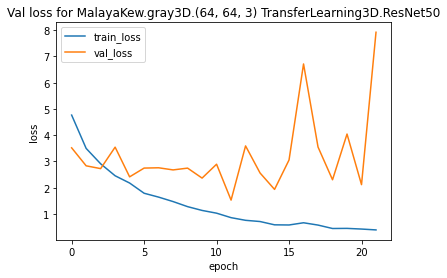

img_path = drive/My Drive/Plant_Leaf_MalayaKew_MK_Dataset/Records/Images/vLoss_MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.png


In [186]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')

img_path = work_dir+'Images/vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

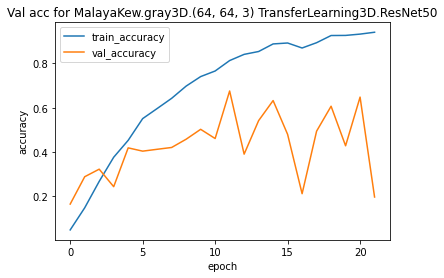

img_path = drive/My Drive/Plant_Leaf_MalayaKew_MK_Dataset/Records/Images/vAcc_MalayaKew.gray3D.(64, 64, 3).pad0.TransferLearning3D.ResNet50.wInit.imagenet.TrainableAfter.allDefault.Dense.512.512.512.512.actF.elu.opt.Adam.drop.0.5.batch64.Flatten.regularizers.l2.0.0001.run_1.png


In [187]:
title = "Val acc for "+dataset+" "+impl_type

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')

img_path = work_dir+'Images/vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)